In [4]:
from pathlib import Path
import pickle
import os
import pandas as pd

# Loop through the parsed text, fill in dataframe along the way
real_dir = Path.cwd() / 'meta_tags_parsed' / 'real'
fake_dir = Path.cwd() / 'meta_tags_parsed' / 'fake'

with open(Path.cwd().parent / 'content_analysis' / 'analyses v2' / '500_real_list.pkl', 'rb') as f:
    real_list = pickle.load(f)
f.close()

with open(Path.cwd().parent / 'content_analysis' / 'analyses v2' / '500_fake_list.pkl', 'rb') as f:
    fake_list = pickle.load(f)
f.close()

with open(Path.cwd().parent / 'content_analysis' / 'analyses v2' / 'html_df_tokenized.pkl', 'rb') as f:
    df = pickle.load(f)
f.close()



def filter_text(source_dir):
    '''
    Takes the meta tags present in all the .txt files at source dir and returns a list of tokens
    present in those txt files
    
    ~~~~ ARGUMENTS ~~~~
    - source_dir : path or str
        - directory containing .txt files of parsed text

    ~~~~ RETURNS ~~~~
    - concat : str
        - large string of concatenated text
    '''
    content = ''
    for text in [source_dir / x for x in os.listdir(source_dir)]:
        with open(text, 'r', encoding='utf8') as f:
            lines = f.readlines()
        f.close()
        
        page_content = ' '.join(lines)

        content = content + ' ' + page_content
            

    # Tokenize
    end_punc = ["'", '"', '!', '?', '.', ')']
    tokenized = tokenize.sent_tokenize(content)
    tokenized = list(set(tokenized))
    to_del = []
    for i in range(len(tokenized)):
        if tokenized[i][-1] not in end_punc:
            to_del.append(i)
    to_del.reverse()
    for d in to_del:
        tokenized.pop(d)
    concat = ' '.join(tokenized)

    return concat

df.head()

,index,site,label,y,text,tokenized
0,0,http://9to5mac.com,real,0,"In a memo that was leaked to the Verge , Cook ...","[memo, wa, leak, verg, cook, say, appl, “, eve..."
1,1,http://wfae.org,real,0,Charlotte Talks Local News Roundup: Housing...,"[charlott, talk, local, news, roundup, hous, f..."
2,2,http://climatefeedback.org,real,0,The workshop will then move to more concrete e...,"[workshop, move, concret, exampl, initi, tackl..."
3,3,http://wdbj7.com,real,0,Power Life by Tony Horton All Adult...,"[power, life, toni, horton, adult, due, larg, ..."
4,4,http://keyc.com,real,0,Good To Know This Recommended by ...,"[good, know, thi, recommend, recommend, high, ..."


In [10]:
content_list = []
for idx, row in df.iterrows():
    dir_ = Path.cwd() / 'meta_tags_parsed' / row.label / str(row['index'])
    
    content = ''
    for text in [dir_ / x for x in os.listdir(dir_)]:
        with open(text, 'r', encoding='utf8') as f:
            lines = f.readlines()
        f.close()

        page_content = ' '.join(lines)

        content = content + ' ' + page_content
    if content == '':
        print(f'no content at {dir_}')
        content += 'none'
    content_list.append(content)

df['meta text'] = content_list
df.head()

no content at c:\Users\ewais\Documents\GitHub\misinfo_detection\meta tag analysis\meta_tags_parsed\fake\7
no content at c:\Users\ewais\Documents\GitHub\misinfo_detection\meta tag analysis\meta_tags_parsed\fake\34
no content at c:\Users\ewais\Documents\GitHub\misinfo_detection\meta tag analysis\meta_tags_parsed\fake\43
no content at c:\Users\ewais\Documents\GitHub\misinfo_detection\meta tag analysis\meta_tags_parsed\fake\85
no content at c:\Users\ewais\Documents\GitHub\misinfo_detection\meta tag analysis\meta_tags_parsed\fake\93
no content at c:\Users\ewais\Documents\GitHub\misinfo_detection\meta tag analysis\meta_tags_parsed\fake\105
no content at c:\Users\ewais\Documents\GitHub\misinfo_detection\meta tag analysis\meta_tags_parsed\fake\109
no content at c:\Users\ewais\Documents\GitHub\misinfo_detection\meta tag analysis\meta_tags_parsed\fake\161
no content at c:\Users\ewais\Documents\GitHub\misinfo_detection\meta tag analysis\meta_tags_parsed\fake\204
no content at c:\Users\ewais\Docum

,index,site,label,y,text,tokenized,meta text
0,0,http://9to5mac.com,real,0,"In a memo that was leaked to the Verge , Cook ...","[memo, wa, leak, verg, cook, say, appl, “, eve...","News and reviews for Apple products, apps, an..."
1,1,http://wfae.org,real,0,Charlotte Talks Local News Roundup: Housing...,"[charlott, talk, local, news, roundup, hous, f...","Charlotte Podcasts,Charlotte music,Charlotte ..."
2,2,http://climatefeedback.org,real,0,The workshop will then move to more concrete e...,"[workshop, move, concret, exampl, initi, tackl...",Scientific Reference to Reliable Information ...
3,3,http://wdbj7.com,real,0,Power Life by Tony Horton All Adult...,"[power, life, toni, horton, adult, due, larg, ...","wdbj, virginia local news, virginia weather, ..."
4,4,http://keyc.com,real,0,Good To Know This Recommended by ...,"[good, know, thi, recommend, recommend, high, ...","keyc, keyc 12 keyc news 12, keyc tv, keyc new..."


In [11]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from tqdm import tqdm

def clean_text(text):
    '''
    cleans text of punctuation, strange characters, and numbers
    '''
    text = str(text)
    text = text.replace("\n", " ").replace("\r", " ")
    punc_list = '!"#$%&()*+, -./:;<=>?@[\]^_{|}~' + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)

    # Replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`", ""))
    text = text.translate(t)

    return text.lower()

def tokenize_dataframe(df, source_col, target_col):
    '''
    Takes df[col] and tokenizes the string into a list of tokens
    '''
    tokenized = []
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    for _, row in tqdm(df.iterrows()):
        text = row[source_col]
        text = clean_text(text)
        tokens = word_tokenize(text)
        lemstem = []
        for word in tokens:
            lemstem.append(porter.stem(lemmatizer.lemmatize(word)))
        final = [w for w in lemstem if not w in stop_words]

        tokenized.append(final)

    df[target_col] = tokenized

    return df

df = tokenize_dataframe(df, 'meta text', 'meta tokenized')

999it [02:09,  7.69it/s]


In [13]:
# Save dataframe
with open('df_tokenized.pkl', 'wb') as f:
    pickle.dump(df, f)
f.close()

In [ ]:
# Load
with open('df_tokenized.pkl', 'rb') as f:
    df = pickle.load(f)
f.close()

ONE MODEL EXAMPLE:


  0%|          | 0/100 [00:00<?, ?it/s]



logistic regression classifier
-------------
accuracy: 95.2 %
baseline: 55.6 %

f1:         0.9559
precision:  0.9774
recall:     0.9353


size of vocab: 7392

   top "real" words top "fake" words
0           vermont            trump
1        pittsburgh             none
2            school           archiv
3            latest            china
4             local            biden
5              base             evid
6              food               hi
7            signal          plandem
8             greek              tea
9              door           altern
10             area               dr
11            cover         michigan
12             team          liberti
13           climat          florida
14            polic          healthi
15           nation               di
16           scienc            truth
17           counti           cancer
18            sport             mind
19          weather       enthusiast


100%|██████████| 100/100 [04:57<00:00,  2.98s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.916348  0.930520     0.944692
1         f1     0.916249  0.930513     0.944778
2  precision     0.905134  0.924283     0.943432
3     recall     0.914772  0.937340     0.959908


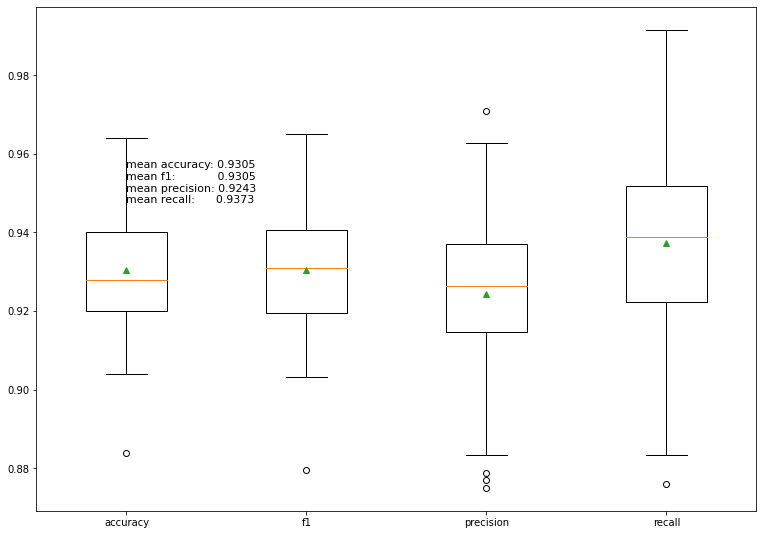

In [14]:
import sys
sys.path.insert(1,r'C:\Users\ewais\Documents\GitHub\misinfo_detection\content_analysis\analyses v2')
from analysis_functions import *

# Analyze
print('ONE MODEL EXAMPLE:')
model, _, X_test, _, y_test, _, vocab = train_logistic_regression(df, 'meta tokenized', meta_name=False)
accuracy, f1, precision, recall = evaluate_logistic_regression(model, X_test, y_test, vocab, PRINT=True)

_ = confidence_interval_logistic_regression(100, df, col='meta tokenized')

## Investigate top logits


In [15]:
with open('df_tokenized.pkl', 'rb') as f:
    df = pickle.load(f)
f.close()

logit_weights, logit_signs, logit_tokens = logit_explained_variance(df, 'meta tokenized', num_iterations=100)

with open('logit_weights.pkl', 'wb') as f:
    pickle.dump(logit_weights,f)
f.close()

with open('logit_signs.pkl', 'wb') as f:
    pickle.dump(logit_signs, f)
f.close()

with open('logit_tokens.pkl', 'wb') as f:
    pickle.dump(logit_tokens, f)
f.close()

100%|██████████| 100/100 [04:59<00:00,  2.99s/it]


In [16]:
for i in range(1,100):
    print('{} : {}'.format(logit_tokens[i], logit_weights[i]))

archiv : 0.018022101638767926
none : 0.016277072223602234
china : 0.016249064986607983
biden : 0.015325373064444979
trump : 0.015292782663558093
counti : -0.013367346514482924
weather : -0.013248398878824723
sport : -0.012667977685359169
citi : -0.011110298145536124
liberti : 0.011086656394900257
area : -0.010709674846096391
scienc : -0.010670338223000408
di : 0.010399717275937834
parent : 0.010313230044762478
page : 0.010268198958442797
evid : 0.01020649548510041
team : -0.00988091501579546
site : 0.009871519971951586
dr : 0.009743872821017928
hi : 0.009671241025588112
climat : -0.009037941186254924
plandem : 0.00886469253379075
polic : -0.008801146835926824
vou : 0.008636074619801636
healthi : 0.008629458239852094
florida : 0.008475290538325004
freedom : 0.008467306374261446
american : 0.008437414660916916
tea : 0.008130034865982015
medium : 0.00799754122006275
altern : 0.007996803120403385
signal : -0.00797333547911106
food : -0.00794236326749263
natur : 0.007892271189562051
friday 